## Game Plan
-team/player shooting vs league average
-% of play types(efficiency vs league average)

1. get team shot charts vs. league average to see the areas where a team shoots well & poorly from
2. get individual shot charts vs. league average to see the areas where each player shoots well & poorly from
3. rank the individual shot charts by volume of shooting

In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle, Arc
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import LinearSegmentedColormap
import urllib, cStringIO
from scipy import misc
%matplotlib inline
import pkg_resources
import os

In [2]:
def court(ax=None, color='black', lw=4, outer_lines=False,direction='up',short_three=False):
    '''
    Plots an NBA court
    outer_lines - accepts False or True. Plots the outer side lines of the court.
    direction - 'up' or 'down' depending on how you like to view the court
    Original function from http://savvastjortjoglou.com/
    '''
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        if direction=='up':
            ax = plt.gca(xlim = [-30,30],ylim = [43,-7],xticks=[],yticks=[],aspect=1.0)
            plt.text(22,44,'By: Doingthedishes',color='black',horizontalalignment='center',fontsize=20,fontweight='bold')
        elif direction=='down':
            ax = plt.gca(xlim = [30,-30],ylim = [-7,43],xticks=[],yticks=[],aspect=1.0)
            plt.text(-22,-7,'By: Doingthedishes',color='black',horizontalalignment='center',fontsize=20,fontweight='bold')
        else:
            ax = plt.gca()
    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    # Diameter of a hoop is 1.5 
    hoop = Circle((0, 0), radius=0.75, linewidth=lw/2, color=color, fill=False)

    # Create backboard
    backboard = Rectangle((-3, -0.75), 6, -0.1, linewidth=lw, color=color)

    # The paint
    # Create the outer box of the paint, width=16ft, height=19ft
    outer_box = Rectangle((-8, -5.25), 16, 19, linewidth=lw, color=color,
                          fill=False)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-6, -5.25), 12, 19, linewidth=lw, color=color,
                          fill=False)

    # Create free throw top arc
    top_free_throw = Arc((0, 13.75), 12, 12, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 13.75), 12, 12, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed')
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 8, 8, theta1=0, theta2=180, linewidth=lw,
                     color=color)

    # Three point line
    if not short_three:
        corner_three_a = Rectangle((-22, -5.25), 0, np.sqrt(23.75**2-22.0**2)+5.25, linewidth=lw,
                                   color=color)
        corner_three_b = Rectangle((22, -5.25), 0, np.sqrt(23.75**2-22.0**2)+5.25, linewidth=lw, color=color)
        # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
        three_arc = Arc((0, 0), 47.5, 47.5, theta1=np.arccos(22/23.75)*180/np.pi, theta2=180.0-np.arccos(22/23.75)*180/np.pi, linewidth=lw,
                        color=color)
    else:
        corner_three_a = Rectangle((-22, -5.25), 0, 5.25, linewidth=lw,
                           color=color)
        corner_three_b = Rectangle((22, -5.25), 0, 5.25, linewidth=lw, color=color)
        # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
        three_arc = Arc((0, 0), 44.0, 44.0, theta1=0, theta2=180, linewidth=lw,
                        color=color)
        # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc]  

    if outer_lines:
        # Draw the half court line, baseline and side out bound lines
        outer_lines = Rectangle((-25, -5.25), 50, 46.75, linewidth=lw,
                                color=color, fill=False)
        center_outer_arc = Arc((0, 41.25), 12, 12, theta1=180, theta2=0,
                                linewidth=lw, color=color)
        center_inner_arc = Arc((0, 41.25), 4, 4, theta1=180, theta2=0,
                                linewidth=lw, color=color)
        court_elements = court_elements + [outer_lines,center_outer_arc,center_inner_arc]
    else:
        ax.plot([-25,25],[-5.25,-5.25],linewidth=lw,color=color)
    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)
#    ax.axis('off')
    return ax

In [3]:
def team_ids():
    response = requests.get('http://stats.nba.com/stats/leaguedashteamstats?Conference=&DateFrom=&DateTo=&Division=&GameScope=&GameSegment=&LastNGames=0&LeagueID=00&Location=&MeasureType=Opponent&Month=0&OpponentTeamID=0&Outcome=&PORound=0&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerExperience=&PlayerPosition=&PlusMinus=N&Rank=N&Season=2017-18&SeasonSegment=&SeasonType=Regular+Season&ShotClockRange=&StarterBench=&TeamID=0&VsConference=&VsDivision=', headers={"USER-AGENT": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/63.0.3239.132 Safari/537.36"})
    data = response.json()
    teams = list()
    for i in range(0, len(data['resultSets'][0]['rowSet'])):
        team_data = data['resultSets'][0]['rowSet'][i][0]
        teams.append(team_data)
    return teams

In [4]:
def team_names():
    response = requests.get('http://stats.nba.com/stats/leaguedashteamstats?Conference=&DateFrom=&DateTo=&Division=&GameScope=&GameSegment=&LastNGames=0&LeagueID=00&Location=&MeasureType=Opponent&Month=0&OpponentTeamID=0&Outcome=&PORound=0&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerExperience=&PlayerPosition=&PlusMinus=N&Rank=N&Season=2017-18&SeasonSegment=&SeasonType=Regular+Season&ShotClockRange=&StarterBench=&TeamID=0&VsConference=&VsDivision=', headers={"USER-AGENT": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/63.0.3239.132 Safari/537.36"})
    data = response.json()
    teams = list()
    for i in range(0, len(data['resultSets'][0]['rowSet'])):
        team_data = data['resultSets'][0]['rowSet'][i][1]
        teams.append(team_data)
    return teams

In [5]:
team_ids = team_ids()
team_names = team_names()

In [6]:
def shot_zone(X,Y):
    '''
    Uses shot coordinates x and y (in feet - divide by 10 if using the shotchart units)
    and returns a tuple with the zone location
    '''
    r = np.sqrt(X**2+Y**2)
    a = np.arctan2(Y,X)*180.0/np.pi
    if (Y<0) & (X > 0):
        a = 0
    elif (Y<0) & (X < 0):
        a = 180
    if r<=8:
        z = ('Less Than 8 ft.','Center(C)')
    elif (r>8) & (r<=16):
        if a < 60:
            z = ('8-16 ft.','Right Side(R)')
        elif (a>=60) & (a<=120):
            z = ('8-16 ft.','Center(C)')
        else:
            z = ('8-16 ft.','Left Side(L)')
    elif (r>16) & (r<=23.75):
        if a < 36:
            z = ('16-24 ft.','Right Side(R)')
        elif (a>=36) & (a<72):
            z = ('16-24 ft.','Right Side Center(RC)')
        elif (a>=72) & (a<=108):
            z = ('16-24 ft.','Center(C)')
        elif (a>108) & (a<144):
            z = ('16-24 ft.','Left Side Center(LC)')
        else:
            z = ('16-24 ft.','Left Side(L)')
    elif r>23.75:
        if a < 72:
            z = ('24+ ft.','Right Side Center(RC)')
        elif (a>=72) & (a<=108):
            z = ('24+ ft.','Center(C)')
        else:
            z = ('24+ ft.','Left Side Center(LC)')
    if (np.abs(X)>=22):
        if (X > 0) & (np.abs(Y)<8.75):
            z = ('24+ ft.','Right Side(R)')
        elif (X < 0) & (np.abs(Y)<8.75):
            z = ('24+ ft.','Left Side(L)')
        elif (X > 0) & (np.abs(Y)>=8.75):
            z = ('24+ ft.','Right Side Center(RC)')
        elif (X < 0) & (np.abs(Y)>=8.75):
            z = ('24+ ft.','Left Side Center(LC)')
    if Y >= 40:
        z = ('Back Court Shot', 'Back Court(BC)')
    return z

In [7]:
def shotchartdetail(leagueid='00',season='2017-18',seasontype='Regular Season',teamid=0,
                    playerid=0,gameid='',outcome='',location='',month=0,
                    seasonseg='',datefrom='',dateto='',oppteamid=0,vsconf='',
                    vsdiv='',pos='',gameseg='',per=0,lastngames=0,aheadbehind='',
                    contextmeasure='FGM',clutchtime='',rookieyear=''):
    '''
    Access to NBA API - http://stats.nba.com/stats/shotchartdetail
    Returns the shotchart requested and the leagueaverage
    Example:
    shot_data,leagueaverage = shotchartdetail(season='2017-18')
    '''
    
    url = 'http://stats.nba.com/stats/shotchartdetail?'
    api_param = {
         'LeagueID': leagueid,
         'Season' :  season,
         'SeasonType' : seasontype,
         'TeamID' : teamid,
         'PlayerID' : playerid,
         'GameID' : gameid,
         'Outcome' : outcome,
         'Location' : location,
         'Month' : month,
         'SeasonSegment' : seasonseg,
         'DateFrom' :  datefrom,
         'DateTo' : dateto,
         'OpponentTeamID' : oppteamid,
         'VsConference' : vsconf,
         'VsDivision' : vsdiv,
         'PlayerPosition' : pos,
         'GameSegment' : gameseg,
         'Period' :  per,
         'LastNGames' : lastngames,
         'AheadBehind' : aheadbehind,
         'ContextMeasure' : contextmeasure,
         'ClutchTime' : clutchtime,
         'RookieYear' : rookieyear
         }
    u_a = "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/63.0.3239.132 Safari/537.36"
    response = requests.get(url,params=api_param,headers={"USER-AGENT":u_a})
    data = response.json()
    Shot_Chart_Detail = pd.DataFrame(data['resultSets'][0]['rowSet'],columns=data['resultSets'][0]['headers'])
    LeagueAverage = pd.DataFrame(data['resultSets'][1]['rowSet'],columns=data['resultSets'][1]['headers'])
    return Shot_Chart_Detail,LeagueAverage

In [36]:
def team_shotchart(shotchart,leagueaverage,ax=None,short_three=False,fg_range=[-9,9],figsize=(12,10),img=None,player=None):
    LA = leagueaverage.loc[:,'SHOT_ZONE_AREA':'FGM'].groupby(['SHOT_ZONE_RANGE','SHOT_ZONE_AREA']).sum()
    LA['FGP'] = 1.0*LA['FGM']/LA['FGA']
    team = shotchart.groupby(['SHOT_ZONE_RANGE','SHOT_ZONE_AREA','SHOT_MADE_FLAG']).size().unstack(fill_value=0)
    team['FGP'] = 1.0*team.loc[:,1]/team.sum(axis=1)
    team_vs_league = (team.loc[:,'FGP'] - LA.loc[:,'FGP'])*100
    x,y = 1.0*shotchart.LOC_X.values/10, 1.0*shotchart.LOC_Y.values/10
    fig = plt.figure()
    poly_hexbins = plt.hexbin(x,y, gridsize=35, extent=[-25,25,-6.25,50-6.25])
    counts = poly_hexbins.get_array()
    verts = poly_hexbins.get_offsets()
    plt.close(fig)
    plt.figure(figsize=figsize,facecolor='white')  # (0,0.17,0.57)
    if ax is None:
        ax = plt.gca(xlim = [30,-30],ylim = [-10,40],xticks=[],yticks=[],aspect=1.0)
    court(ax,outer_lines=False,color='black',lw=4.0,direction='down',short_three=short_three);
    ax.axis('off')
    #nba.plot.zones()
    #s=0.8747731368853422
    s = 0.85
    bins = np.concatenate([[-np.inf],np.linspace(fg_range[0],fg_range[1],200),[np.inf]])
    colors = [(0.66, 0.75, 0.66),(0.9,1.0,0.6), (0.8, 0, 0)]
    cm = LinearSegmentedColormap.from_list('my_list', colors, N=len(bins)-1)
    xy = s*np.array([np.cos(np.linspace(np.pi/6,np.pi*330/180,6)),np.sin(np.linspace(np.pi/6,np.pi*330/180,6))]).T
    b = np.zeros((6,2))
    counts_norm = np.zeros_like(counts)
    counts_norm[counts>=4] = 1
    counts_norm[(counts>=2) & (counts<4)] = 0.5
    counts_norm[(counts>=1) & (counts<2)] = 0.3
    patches=[]
    colors=[]
    for offc in range(verts.shape[0]):
        if counts_norm[offc] != 0:
            xc,yc = verts[offc][0],verts[offc][1] 
            b[:,0] = xy[:,0]*counts_norm[offc] + xc
            b[:,1] = xy[:,1]*counts_norm[offc] + yc
            if not short_three:
                p_diff = team_vs_league.loc[shot_zone(xc,yc)]
            else:
                p_diff = team_vs_league.loc[shot_zone_short_three(xc,yc)]
            inds = np.digitize(p_diff, bins,right=True)-1
            patches.append(Polygon(b))
            colors.append(inds)
          
    for i in range(5):
        xc = 21-2*0.76*i
        yc = -7
        b[:,0] = xy[:,0] + xc
        b[:,1] = xy[:,1] + yc
        patches.append(Polygon(b))
        colors.append(i*50)
    plt.text(21,-8.5,'Cold',horizontalalignment='center',verticalalignment='center')
    plt.text(21-2*0.76*4,-8.5,'Hot',horizontalalignment='center',verticalalignment='center')
    
    xc = -14.5
    yc = -7.0
    plt.text(xc,-8.5,'Less',horizontalalignment='center',verticalalignment='center')
    b[:,0] = xy[:,0]*0.3 + xc
    b[:,1] = xy[:,1]*0.3 + yc
    patches.append(Polygon(b))
    colors.append(100)
    xc = -16
    b[:,0] = xy[:,0]*0.50 + xc
    b[:,1] = xy[:,1]*0.50 + yc
    patches.append(Polygon(b))
    colors.append(100)
    xc = -18
    b[:,0] = xy[:,0] + xc
    b[:,1] = xy[:,1] + yc
    plt.text(xc,-8.5,'More',horizontalalignment='center',verticalalignment='center')
    
    patches.append(Polygon(b))
    colors.append(100)

    p = PatchCollection(patches,cmap=cm,alpha=1, linewidths=.5, edgecolors='k')
    p.set_array(np.array(colors))
    ax.add_collection(p)
    p.set_clim([0, len(bins)-1])
    
    if img is not None:
        #ax.imshow(img,extent=[15,25,30,37.8261])
        plt.text(20,40,shotchart['TEAM_NAME'][0],fontsize=16,horizontalalignment='center',verticalalignment='center')
    if player is not None:
        plt.text(20,40,player,fontsize=16,horizontalalignment='center',verticalalignment='center')

In [37]:
atl_shotchart, avg = shotchartdetail(
    season="2017-18", teamid=team_ids[0]
)
bos_shotchart, avg = shotchartdetail(
    season="2017-18", teamid=team_ids[1]
)
bro_shotchart, avg = shotchartdetail(
    season="2017-18", teamid=team_ids[2]
)
cha_shotchart, avg = shotchartdetail(
    season="2017-18", teamid=team_ids[3]
)
chi_shotchart, avg = shotchartdetail(
    season="2017-18", teamid=team_ids[4]
)
cle_shotchart, avg = shotchartdetail(
    season="2017-18", teamid=team_ids[5]
)
dal_shotchart, avg = shotchartdetail(
    season="2017-18", teamid=team_ids[6]
)
den_shotchart, avg = shotchartdetail(
    season="2017-18", teamid=team_ids[7]
)
det_shotchart, avg = shotchartdetail(
    season="2017-18", teamid=team_ids[8]
)
gol_shotchart, avg = shotchartdetail(
    season="2017-18", teamid=team_ids[9]
)
hou_shotchart, avg = shotchartdetail(
    season="2017-18", teamid=team_ids[10]
)
ind_shotchart, avg = shotchartdetail(
    season="2017-18", teamid=team_ids[11]
)
lac_shotchart, avg = shotchartdetail(
    season="2017-18", teamid=team_ids[12]
)
lal_shotchart, avg = shotchartdetail(
    season="2017-18", teamid=team_ids[13]
)
mem_shotchart, avg = shotchartdetail(
    season="2017-18", teamid=team_ids[14]
)
mia_shotchart, avg = shotchartdetail(
    season="2017-18", teamid=team_ids[15]
)
mil_shotchart, avg = shotchartdetail(
    season="2017-18", teamid=team_ids[16]
)
min_shotchart, avg = shotchartdetail(
    season="2017-18", teamid=team_ids[17]
)
nop_shotchart, avg = shotchartdetail(
    season="2017-18", teamid=team_ids[18]
)
nyk_shotchart, avg = shotchartdetail(
    season="2017-18", teamid=team_ids[19]
)
okc_shotchart, avg = shotchartdetail(
    season="2017-18", teamid=team_ids[20]
)
orl_shotchart, avg = shotchartdetail(
    season="2017-18", teamid=team_ids[21]
)
phi_shotchart, avg = shotchartdetail(
    season="2017-18", teamid=team_ids[22]
)
pho_shotchart, avg = shotchartdetail(
    season="2017-18", teamid=team_ids[23]
)
por_shotchart, avg = shotchartdetail(
    season="2017-18", teamid=team_ids[24]
)
sac_shotchart, avg = shotchartdetail(
    season="2017-18", teamid=team_ids[25]
)
san_shotchart, avg = shotchartdetail(
    season="2017-18", teamid=team_ids[26]
)
tor_shotchart, avg = shotchartdetail(
    season="2017-18", teamid=team_ids[27]
)
uta_shotchart, avg = shotchartdetail(
    season="2017-18", teamid=team_ids[28]
)
was_shotchart, avg = shotchartdetail(
    season="2017-18", teamid=team_ids[29]
)

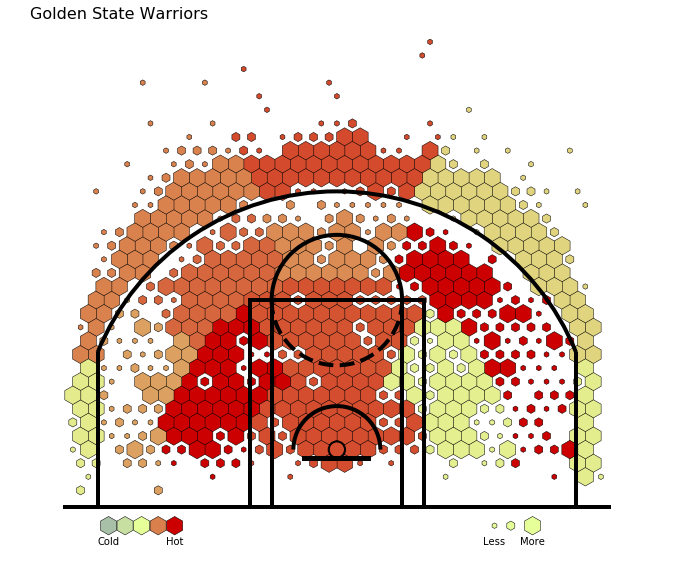

In [39]:
team_shotchart(gol_shotchart, avg, img='gol.png')

In [75]:
def players_shotchart(shotchart,leagueaverage,ax=None,short_three=False,fg_range=[-9,9],figsize=(12,10),img=None):
    team_players_by_shot_volume = shotchart.groupby('PLAYER_NAME').count().sort_values('GRID_TYPE', ascending=False) #ranking players by shot volume
    team_players = team_players_by_shot_volume.index 
    for player in team_players:
        if len(shotchart[shotchart['PLAYER_NAME'] == player]) >= 100: #only includes players who've taken over 100 shots
            team_shotchart(shotchart[shotchart['PLAYER_NAME'] == player], leagueaverage, player=player)

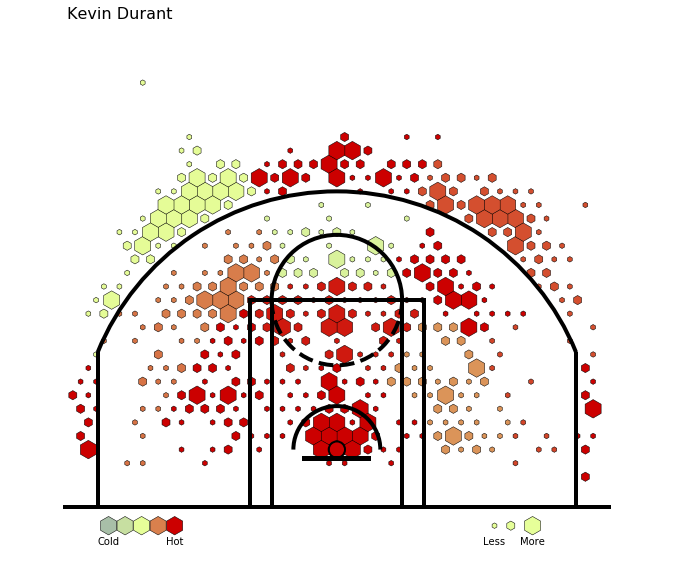

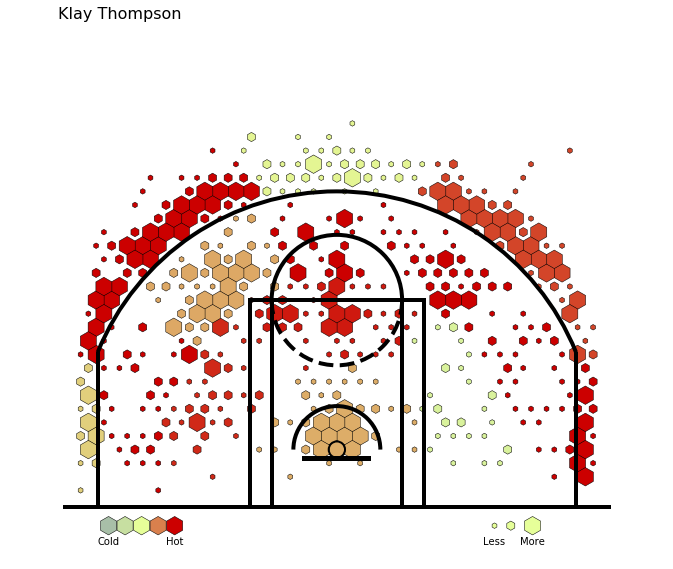

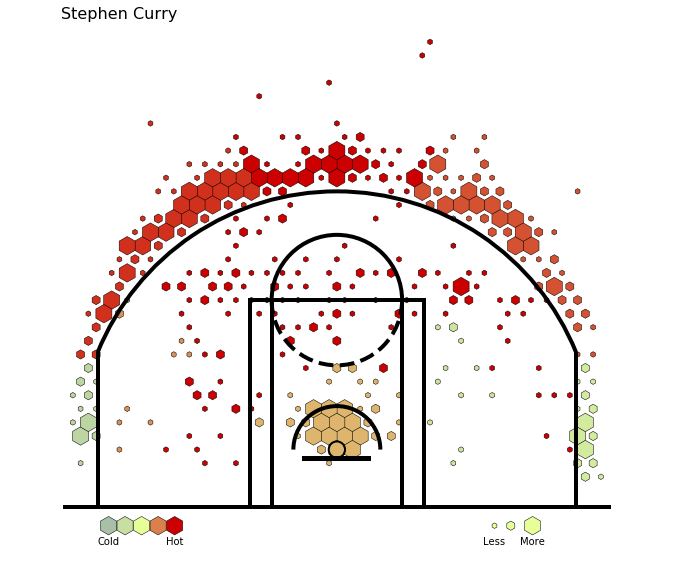

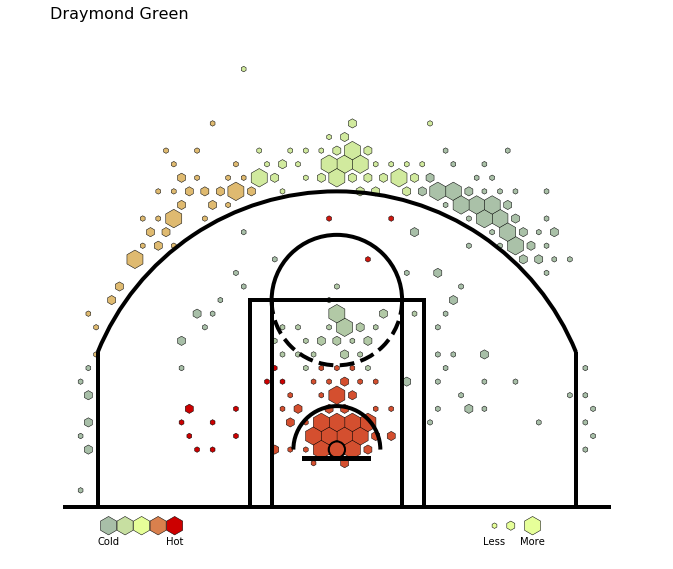

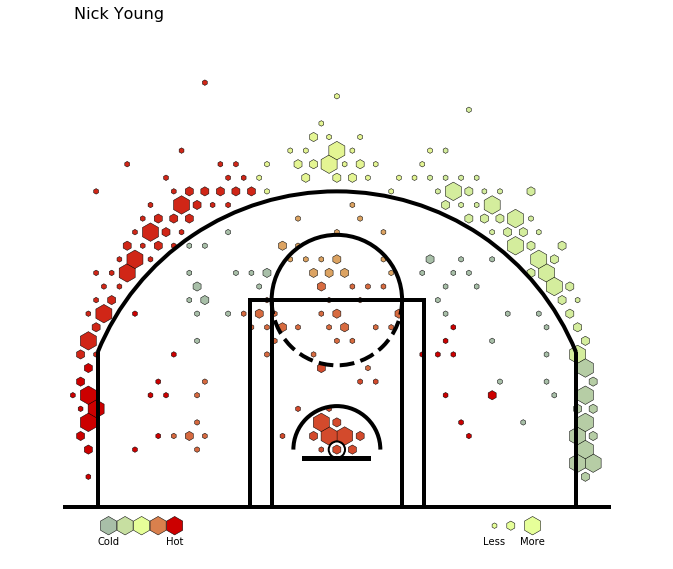

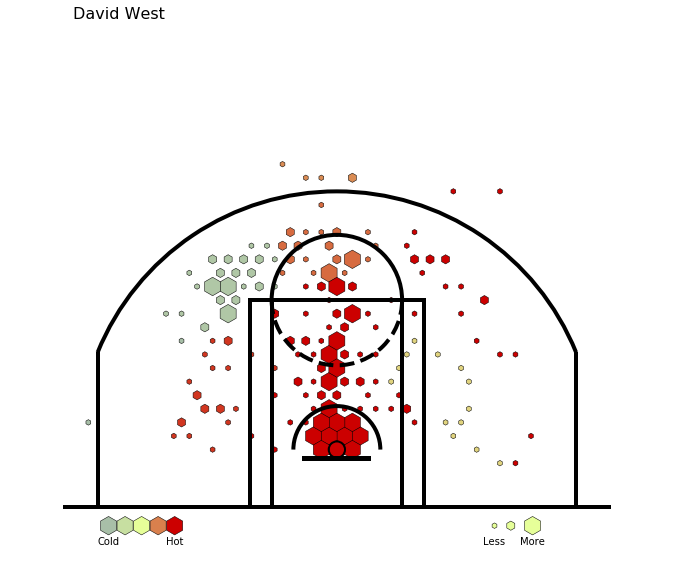

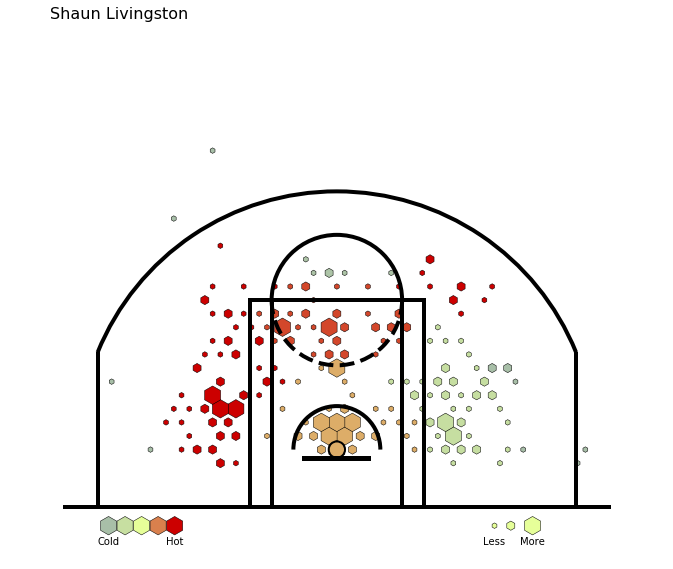

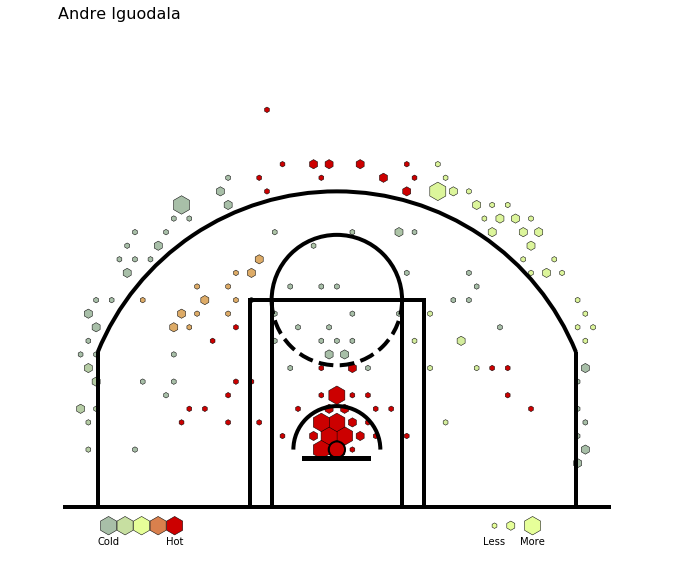

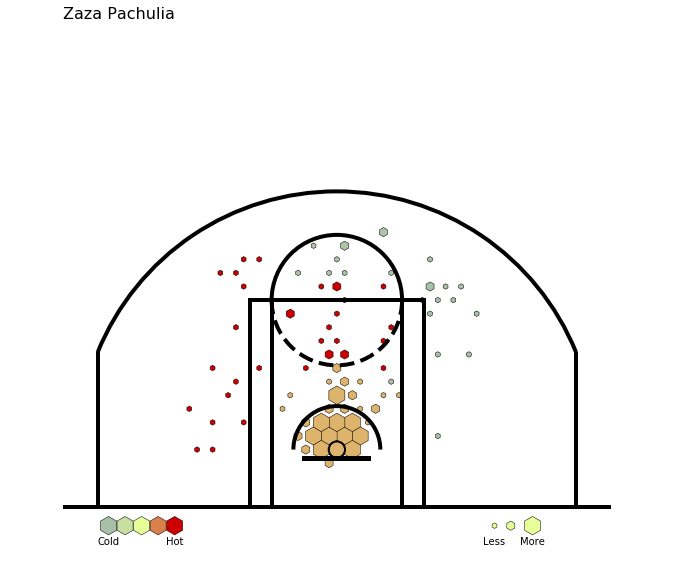

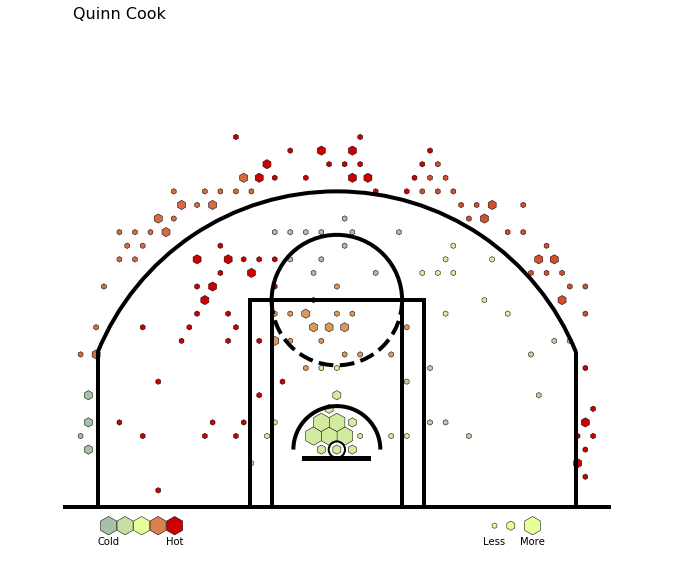

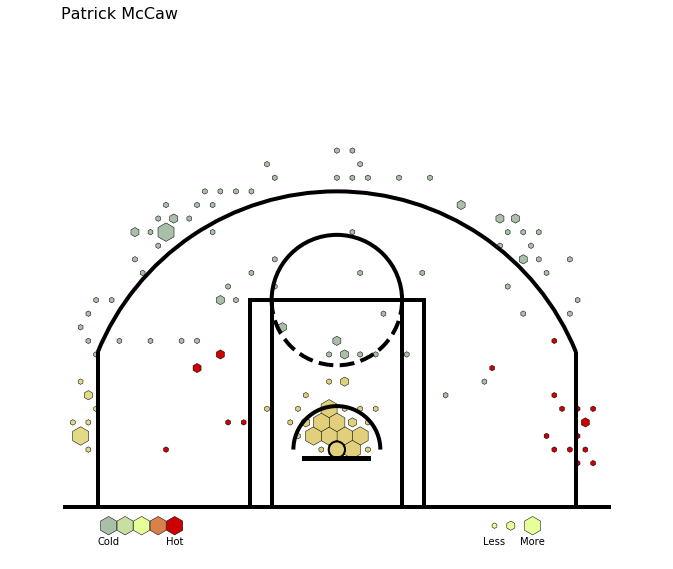

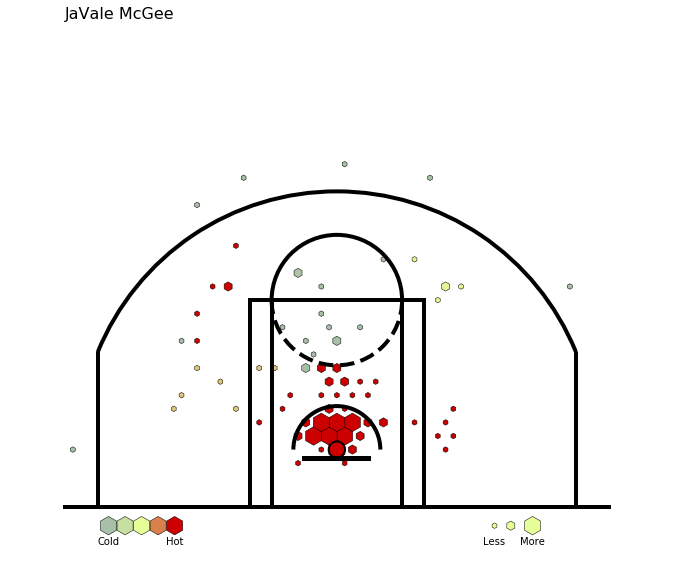

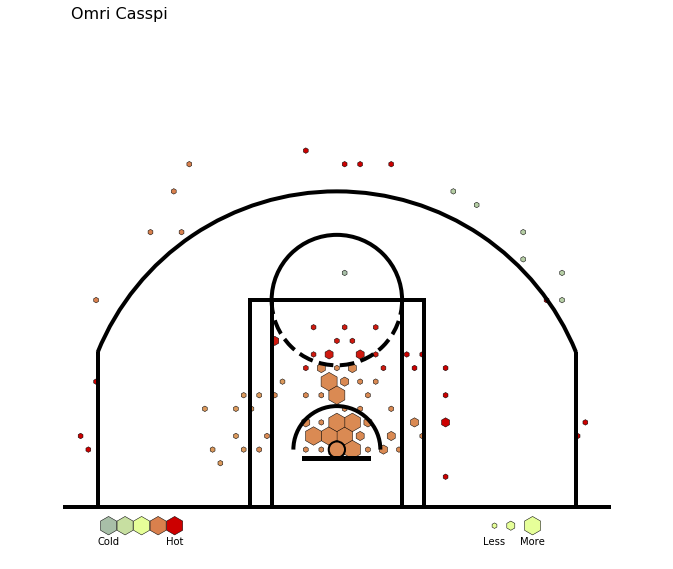

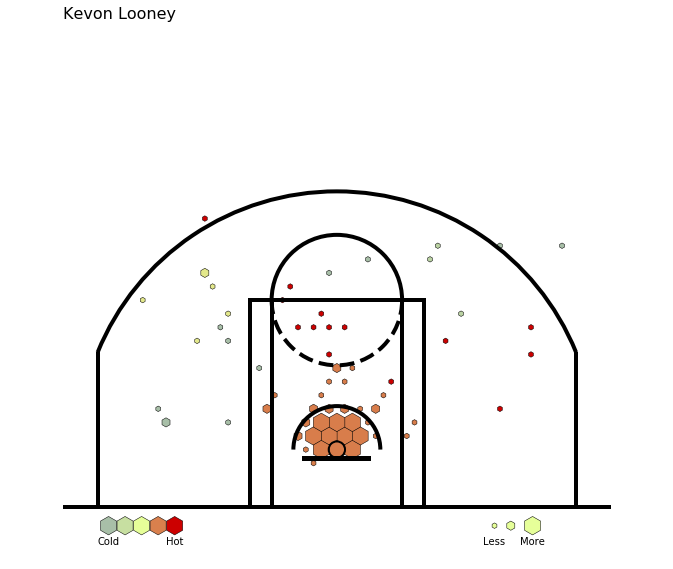

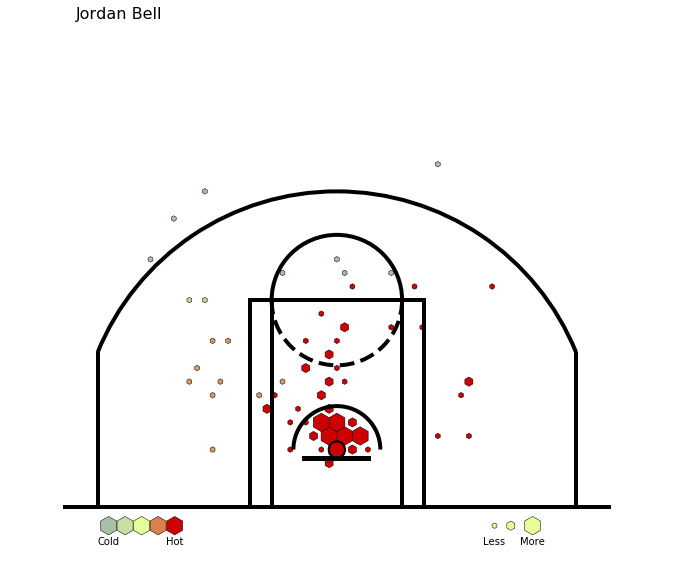

In [76]:
players_shotchart(gol_shotchart, avg)